# Camera Configuration Diagnostics

The purpose of this notebook is to examine the accuracy of the camera array configuration both before and after bundle adjustment.

In [19]:
from pathlib import Path
import pickle
import sys

# some convenient reference paths
repo = str(Path.cwd()).split("src")[0]
# update path
sys.path.insert(0,repo)
# which enables import of relevant class
from src.cameras.camera_array import ArrayDiagnosticData

calibration_directory = Path(repo, "sessions", "iterative_adjustment", "recording")

before_path = Path(calibration_directory,"before_bund_adj.pkl")
after_path = Path(calibration_directory,"after_bund_adj.pkl")

with open(before_path, "rb") as file:
    before = pickle.load(file)

with open(after_path, "rb") as file:
    after = pickle.load(file)
    

In [20]:
    
import numpy as np
import pandas as pd
CAMERA_PARAM_COUNT = 6

def create_summary_df(array_data:ArrayDiagnosticData, label):
    array_data_xy_error = array_data.xy_reprojection_error.reshape(-1,2)
    # build out error as singular distanc
    
    n_cameras = len(array_data.camera_array.cameras)
    print(n_cameras)
    xyz = array_data.model_params[n_cameras*CAMERA_PARAM_COUNT:]
    xyz = xyz.reshape(-1,3)
    print(xyz) 
    
    euclidean_distance_error = np.sqrt(np.sum(array_data_xy_error ** 2, axis=1))
    row_count = euclidean_distance_error.shape[0]
    array_data_dict = {
        "label": [label]*row_count,
        "camera": array_data.point_data.camera_indices_full.tolist(),
        "sync_index": array_data.point_data.sync_indices.tolist(),
        "charuco_id": array_data.point_data.corner_id.tolist(),
        "img_x": array_data.point_data.img_full[:,0].tolist(), 
        "img_y": array_data.point_data.img_full[:,1].tolist(), 
        "reproj_error_x": array_data_xy_error[:, 0].tolist(),
        "reproj_error_y": array_data_xy_error[:, 1].tolist(),
        "reproj_error": euclidean_distance_error.tolist(),
        "obj_id": array_data.point_data.obj_indices.tolist(),
        "obj_x": xyz[array_data.point_data.obj_indices_full][:,0].tolist(),
        "obj_y": xyz[array_data.point_data.obj_indices_full][:,1].tolist(),
        "obj_z": xyz[array_data.point_data.obj_indices_full][:,2].tolist(),
    
    }

    array_data_df = pd.DataFrame(array_data_dict)
    return array_data_df

before_df = create_summary_df(before, "before")
after_df = create_summary_df(after, "after")

before_and_after = pd.concat([before_df, after_df])


3
[[-0.03321194  0.32097542  0.72080874]
 [ 0.02017693  0.32596341  0.72668576]
 [-0.1208517   0.31524786  0.74730575]
 ...
 [-0.18700998  0.03452579  0.67723078]
 [-0.21204661  0.0272406   0.72098577]
 [-0.23660465  0.01923446  0.764705  ]]
3
[[-0.0309959   0.32053184  0.72199918]
 [ 0.02227035  0.32436391  0.72858281]
 [-0.1188777   0.3143545   0.74846716]
 ...
 [-0.18767123  0.037084    0.67304088]
 [-0.21226636  0.02938249  0.71666316]
 [-0.23657568  0.02132243  0.76021462]]


## (x,y) Reprojection Error

In [21]:
before_and_after.groupby(["label"])["reproj_error"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
after,8164.0,1.406193,1.328701,0.000654,0.520596,1.016422,1.833510,11.237583
before,8164.0,1.558270,1.420769,0.002509,0.571524,1.155570,2.096138,12.224042


In [22]:
reproj_error = before_and_after.query("label == 'before'")["reproj_error"].to_numpy()
rmse = np.sqrt(np.mean(reproj_error**2))
print(f"RMSE of reprojection prior to bundle adjustment is {rmse}")

reproj_error = before_and_after.query("label == 'after'")["reproj_error"].to_numpy()
rmse = np.sqrt(np.mean(reproj_error**2))
print(f"RMSE of reprojection after bundle adjustment is {rmse}")

RMSE of reprojection prior to bundle adjustment is 2.1086826971211843
RMSE of reprojection after bundle adjustment is 1.9345824743672753


In [23]:

before_and_after.groupby(["camera", "label"])["reproj_error"].describe()

count      mean       std       min       25%       50%  \
camera label                                                              
0      after   2854.0  1.301992  1.386501  0.001028  0.465299  0.886900   
       before  2854.0  1.566384  1.543532  0.005321  0.554469  1.088745   
1      after   2982.0  1.169298  1.145356  0.000654  0.408448  0.829062   
       before  2982.0  1.412344  1.288629  0.002509  0.483671  1.063775   
2      after   2328.0  1.837383  1.372737  0.004685  0.878418  1.487919   
       before  2328.0  1.735243  1.405025  0.006098  0.746128  1.369458   

                    75%        max  
camera label                        
0      after   1.537246  11.237583  
       before  2.016033  12.224042  
1      after   1.508160   9.550254  
       before  1.962420   9.467979  
2      after   2.486841  10.832059  
       before  2.366817  12.098700

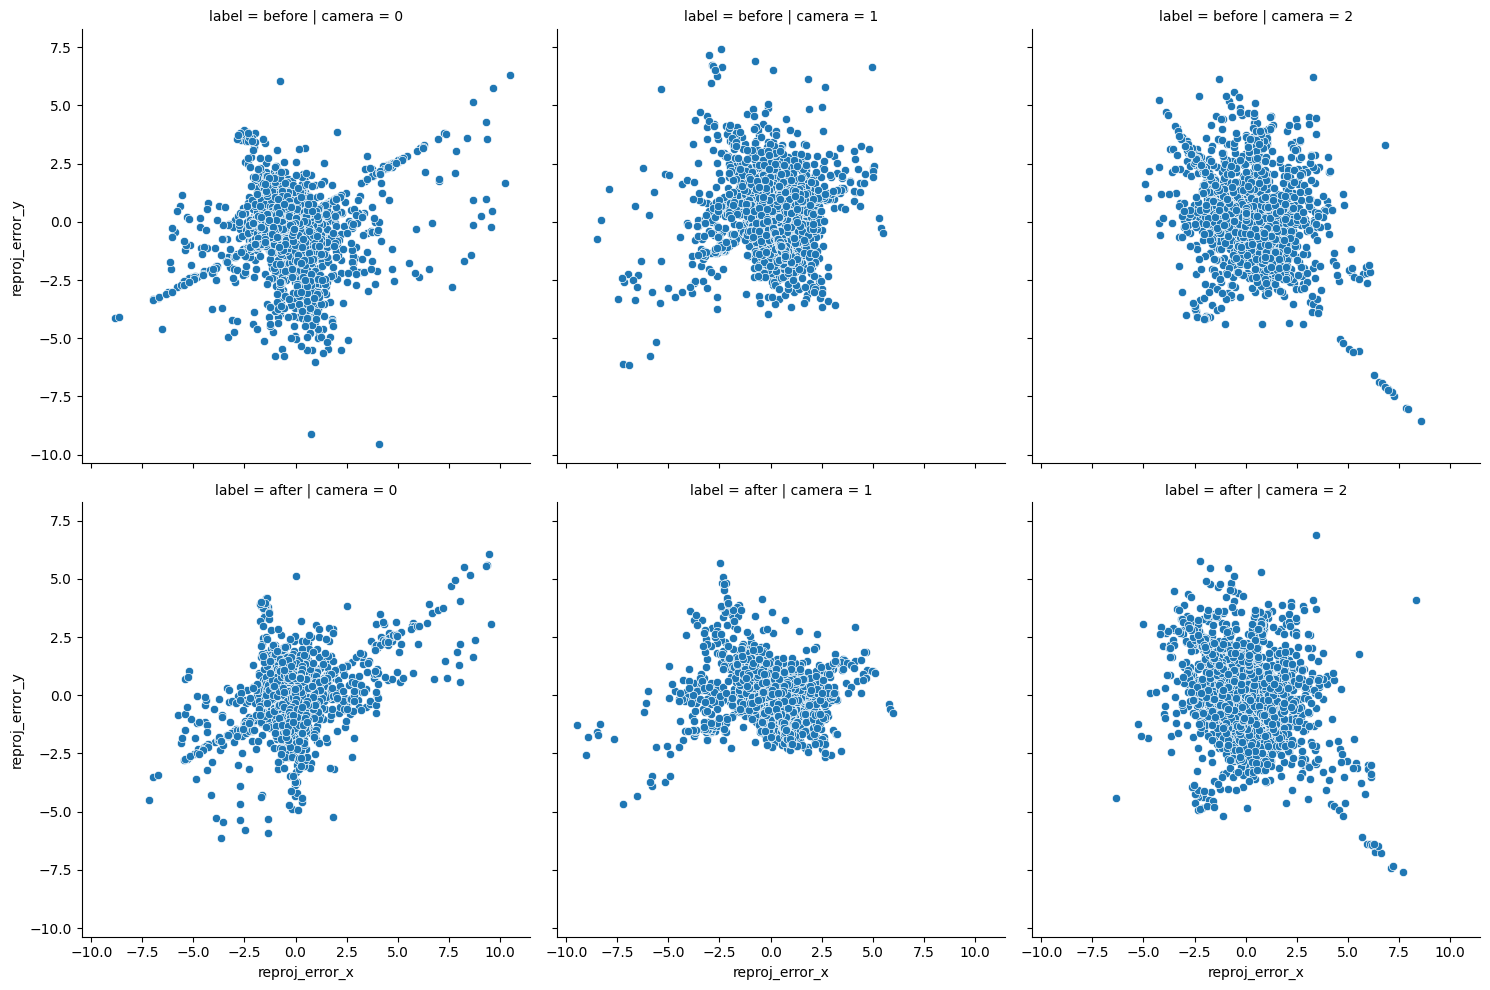

In [24]:
import seaborn as sns

sns.relplot(
    data=before_and_after,
    x="reproj_error_x",
    y="reproj_error_y",
    col="camera",
    row="label",
    kind="scatter",
)

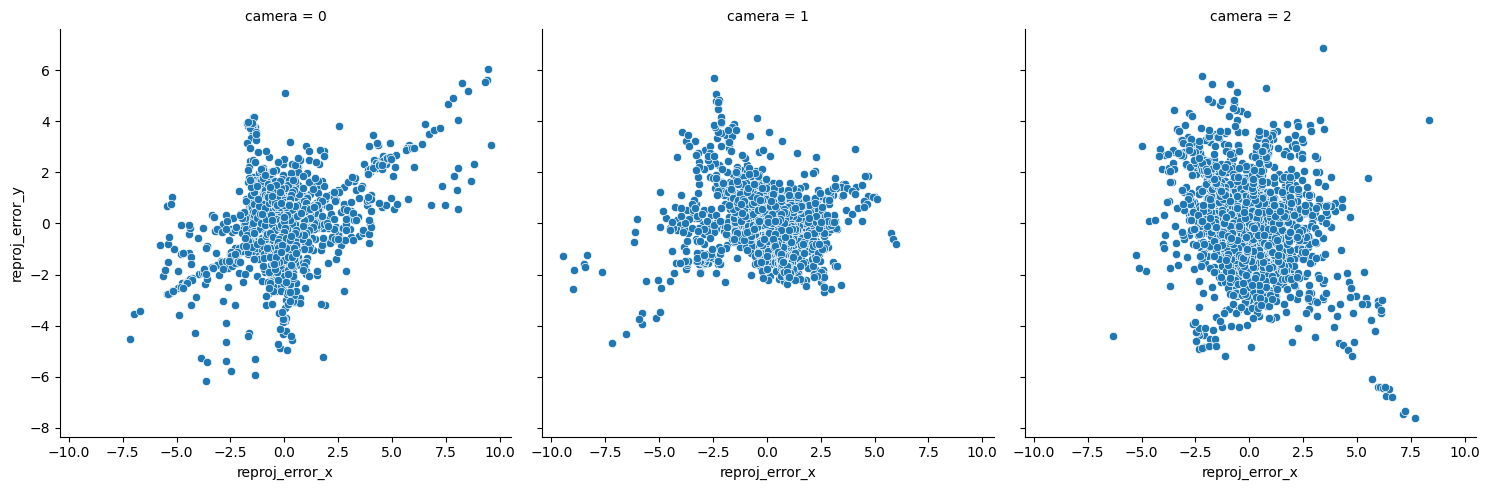

In [25]:

sns.relplot(
    data=after_df,
    x="reproj_error_x",
    y="reproj_error_y",
    col="camera",
    # row="label",
    kind="scatter",
)

## Euclidian Distance Reprojection Error 

### Histogram Before and After

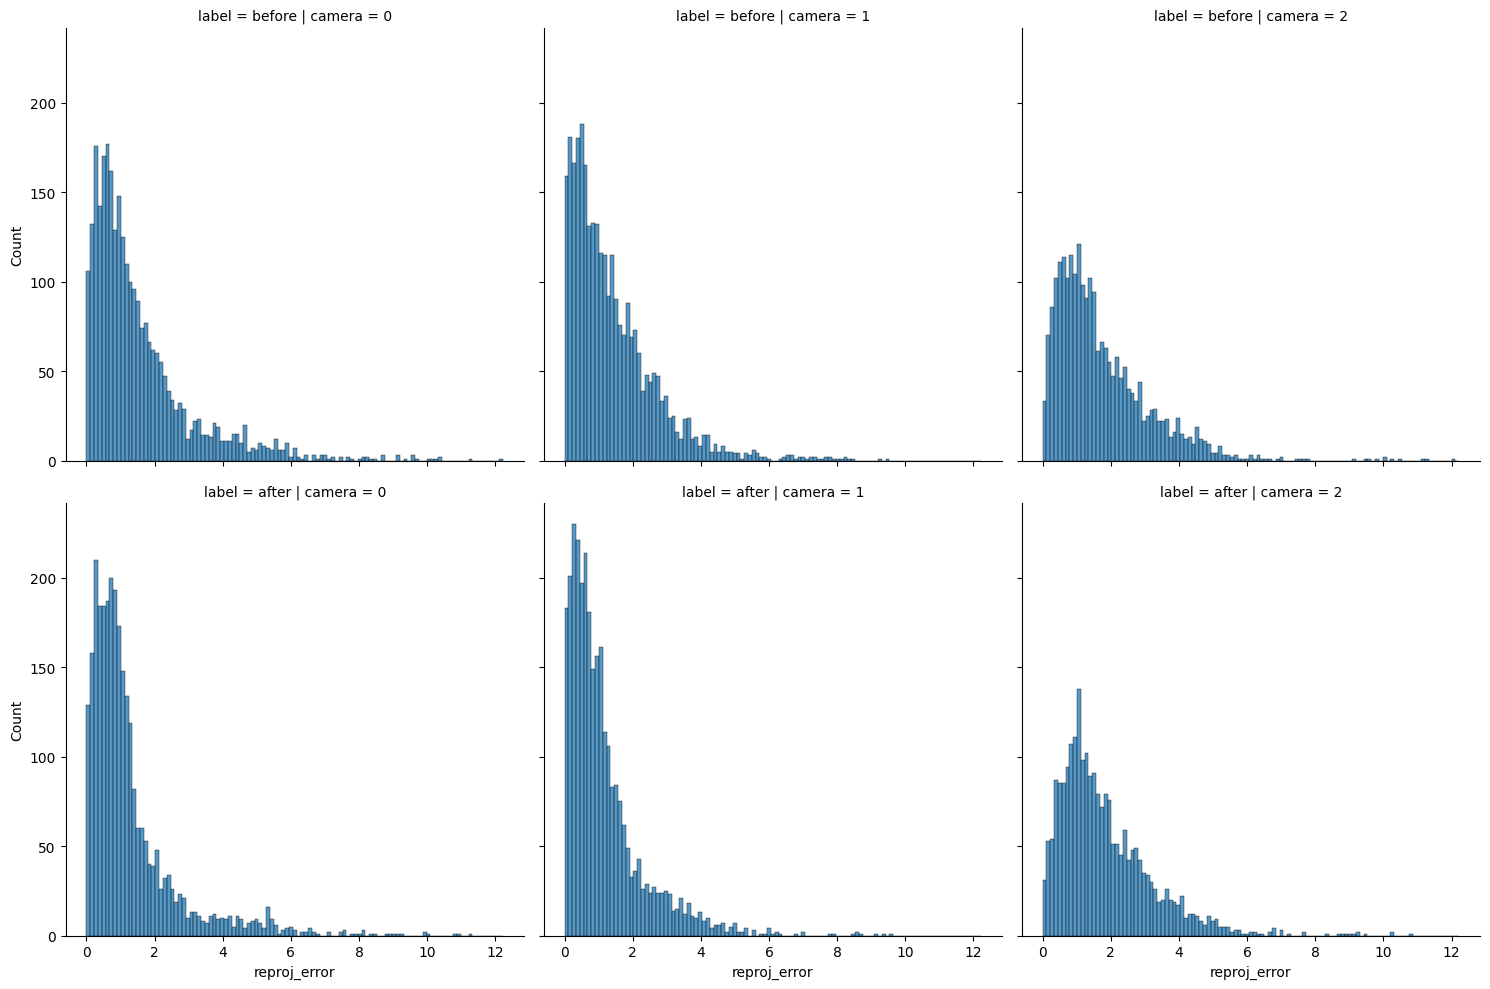

In [26]:

sns.displot(
    data= before_and_after,
    x="reproj_error",
    col="camera",
    row="label",
)

### Box Plot Before and After

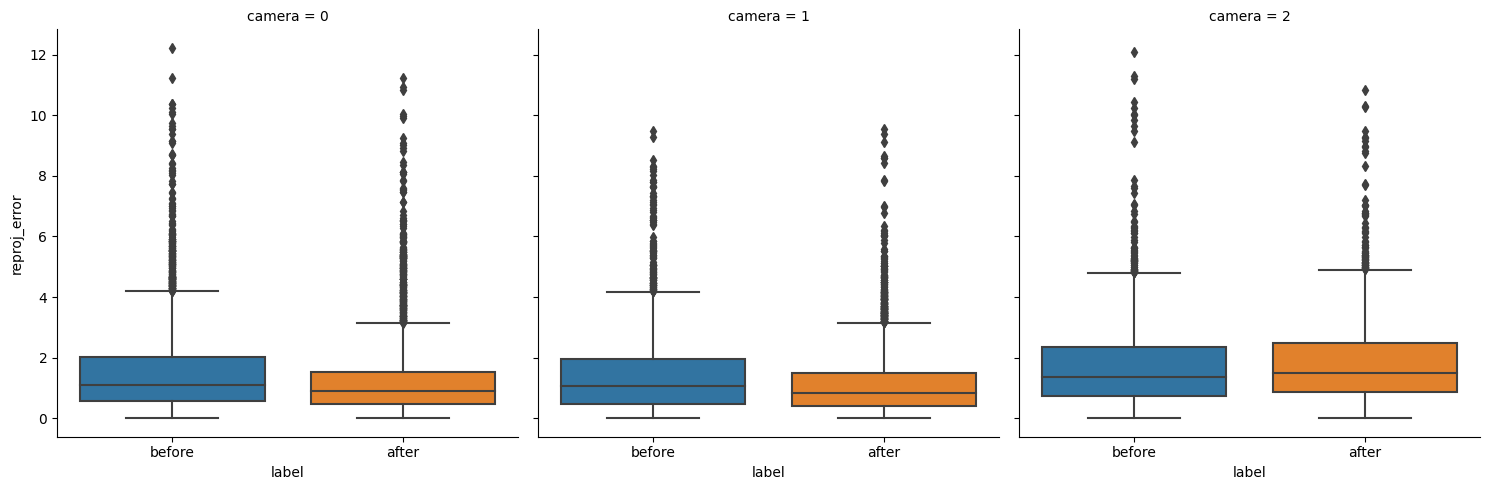

In [27]:
sns.catplot(
    data=before_and_after, 
    x="label", 
    y="reproj_error", 
    col="camera", 
    kind="box"
)

## Charuco Corner Distance

In [28]:
# Import charuco object
## get config
import toml
from src.calibration.charuco import Charuco

config_path = Path(calibration_directory.parent, "config.toml")

config = toml.load(config_path)

## create charuco
charuco = Charuco(
    columns=config["charuco"]["columns"],
    rows=config["charuco"]["rows"],
    board_height=config["charuco"]["board_height"],
    board_width=config["charuco"]["rows"],
    dictionary=config["charuco"]["dictionary"],
    units=config["charuco"]["units"],
    aruco_scale=config["charuco"]["aruco_scale"],
    square_size_overide_cm=config["charuco"]["square_size_overide_cm"],
    inverted=config["charuco"]["inverted"],
)

In [29]:
# Get array of chessboard_ids and locations in a board frame of referencefrom before_and_after
corners = before_and_after["charuco_id"].to_numpy()
xyz_corner_loc = charuco.board.chessboardCorners[corners, :]

corners_3d = (before_and_after[
    ["label", "sync_index", "charuco_id", "obj_id", "obj_x", "obj_y", "obj_z"]
]
                .groupby(["label","obj_id"])
                .mean()
                .reset_index()
)


In [30]:

from itertools import combinations

labels = corners_3d["label"].unique()
corner_ids = corners_3d["charuco_id"].unique()

corner_distances = {
    "label": [],
    "sync_index": [],
    "pair": [],
    "distance_true": [],
    "distance_measured": [],
}


for label in labels:
    by_label_df = corners_3d[corners_3d["label"] == label]
    # sub_df = corners_3d.filter
    sync_indices = by_label_df["sync_index"].unique()

    for sync_index in sync_indices:
        by_sync_index_df = by_label_df[by_label_df["sync_index"] == sync_index]
        corners = by_sync_index_df["charuco_id"]
        pairs = combinations(corners.tolist(), 2)

        corner_loc_world = by_sync_index_df[["obj_x", "obj_y", "obj_x"]].to_numpy()
        charuco_id = by_sync_index_df[["charuco_id"]]


        for pair in pairs:
            # print(pair)
            loc_A_board = charuco.board.chessboardCorners[int(pair[0])]
            loc_B_board = charuco.board.chessboardCorners[int(pair[1])]

            distance_true = np.sqrt(np.sum((loc_A_board - loc_B_board) ** 2))

            loc_A_world = by_sync_index_df[by_sync_index_df["charuco_id"] == pair[0]][
                ["obj_x", "obj_y", "obj_z"]
            ].to_numpy()[0]

            loc_B_world = by_sync_index_df[by_sync_index_df["charuco_id"] == pair[1]][
                ["obj_x", "obj_y", "obj_z"]
            ].to_numpy()[0]
            
            distance_measured = np.sqrt(np.sum((loc_A_world - loc_B_world) ** 2))

            corner_distances["label"].extend([label])
            corner_distances["sync_index"].extend([sync_index])
            corner_distances["pair"].extend([pair])
            corner_distances["distance_true"].extend([distance_true])
            corner_distances["distance_measured"].extend([distance_measured])

        print(f"{label}: Sync Index {sync_index}")
        # for corner_id in corner_ids:

after: Sync Index 30.0
after: Sync Index 31.0
after: Sync Index 32.0
after: Sync Index 33.0
after: Sync Index 34.0
after: Sync Index 35.0
after: Sync Index 36.0
after: Sync Index 37.0
after: Sync Index 38.0
after: Sync Index 39.0
after: Sync Index 40.0
after: Sync Index 41.0
after: Sync Index 42.0
after: Sync Index 43.0
after: Sync Index 44.0
after: Sync Index 45.0
after: Sync Index 46.0
after: Sync Index 47.0
after: Sync Index 48.0
after: Sync Index 49.0
after: Sync Index 50.0
after: Sync Index 51.0
after: Sync Index 52.0
after: Sync Index 53.0
after: Sync Index 54.0
after: Sync Index 55.0
after: Sync Index 56.0
after: Sync Index 57.0
after: Sync Index 58.0
after: Sync Index 59.0
after: Sync Index 60.0
after: Sync Index 61.0
after: Sync Index 62.0
after: Sync Index 63.0
after: Sync Index 64.0
after: Sync Index 65.0
after: Sync Index 66.0
after: Sync Index 67.0
after: Sync Index 68.0
after: Sync Index 69.0
after: Sync Index 70.0
after: Sync Index 71.0
after: Sync Index 72.0
after: Sync

In [31]:
corner_distances_df = pd.DataFrame(corner_distances)
corner_distances_df = corner_distances_df.assign(distance_true = lambda x: round(x.distance_true,4),
                           Distance_error_m = lambda x: round(x.distance_true - x.distance_measured,4),
                           Distance_error_mm = lambda x: x.Distance_error_m * 1000,
                           Distance_error_mm_abs = lambda x: abs(x.Distance_error_mm),
                           Distance_error_pct = lambda x: x.Distance_error_mm/ x.distance_true )


## Percentiles of Absolute Value of Distance Error (mm)

In [32]:
corner_distances_df.groupby("label")["Distance_error_mm_abs"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
after,16119.0,1.982939,2.455576,0.0,0.6,1.3,2.5,53.9
before,16119.0,2.028631,2.622765,0.0,0.6,1.3,2.5,58.7


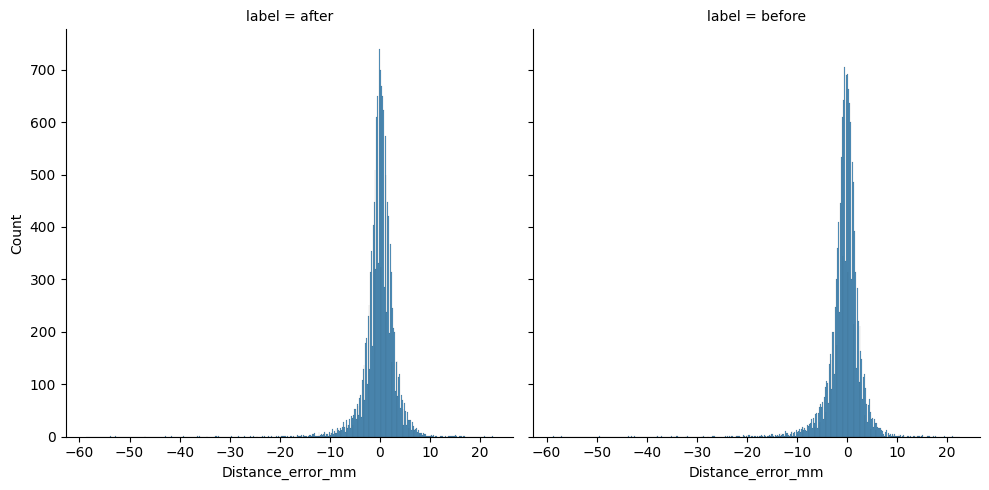

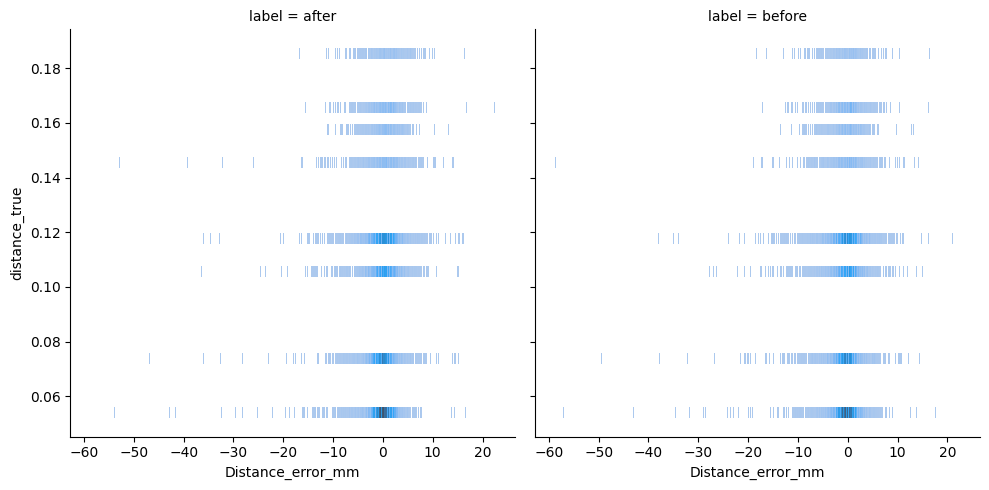

In [33]:
sns.displot(data=corner_distances_df, col="label", x="Distance_error_mm")
sns.displot(data=corner_distances_df, col="label", x="Distance_error_mm", y = "distance_true")

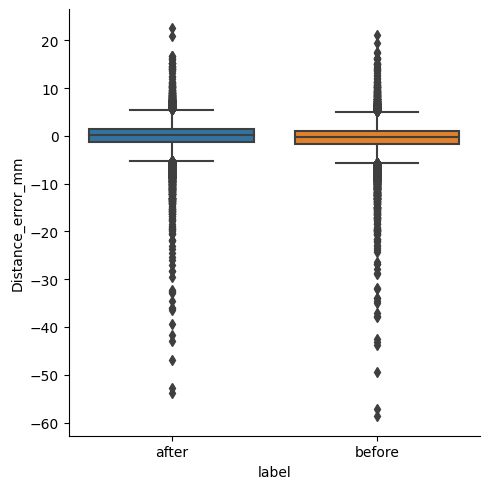

In [34]:

# sns.catplot(data=corner_distances_df, col="label", x="Distance_error_mm", kind="Box")

sns.catplot(
    data=corner_distances_df, 
    x="label", 
    y="Distance_error_mm", 
    kind="box"
)